# CAPÍTULO 4: PREPROCESAMIENTO DE DATOS


In [ ]:
# Importar configuración compartida y utilidades
import sys
sys.path.append('..')
from config import *
from utils.data_loader import save_data_product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib


In [ ]:
# Cargar datos
df = pd.read_csv(os.path.join(RAW_DATA_DIR, 'heart.csv'))
print(f"Dataset cargado: {df.shape}")


<a id='36-hallazgos'></a>
## 3.6 Resumen de Hallazgos del EDA

### Principales Insights

**1. Calidad de los Datos:**
- ✅ Dataset completo sin valores faltantes
- ✅ 303 observaciones válidas
- ⚠️ Presencia de outliers en algunas variables (conservados por relevancia clínica)

**2. Variable Objetivo:**
- Distribución relativamente balanceada (verificar con código)
- Clasificación binaria apropiada para el problema clínico

**3. Variables Más Predictivas (según correlación):**
- [Completar con resultados reales del análisis]
- Variables con correlación fuerte: [listar]
- Variables con correlación moderada: [listar]

**4. Observaciones Clínicas Relevantes:**
- [Completar según hallazgos del análisis bivariado]
- Diferencias significativas entre grupos en: [listar variables]
- Patrones identificados: [describir]

**5. Consideraciones para Preprocesamiento:**
- No se requiere imputación (dataset completo)
- Escalamiento necesario para modelos sensibles a escala (Logistic Regression)
- Evaluar creación de features basados en conocimiento clínico
- Considerar técnicas de balanceo si el ratio es <0.8 o >1.25

**6. Próximos Pasos:**
- Preprocesamiento de datos
- Feature engineering basado en correlaciones observadas
- Selección de variables más relevantes

In [15]:
# Código para generar resumen automático
print("\n" + "="*80)
print("RESUMEN EJECUTIVO DEL EDA")
print("="*80)

print(f"""
📊 DATASET:
   • Tamaño: {df.shape[0]} observaciones × {df.shape[1]} variables
   • Completitud: {(1 - df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100:.1f}%
   • Balance de clases: [A calcular según análisis previo]

📈 VARIABLES CONTINUAS:
   • Total: {len(continuous_vars)}
   • Con distribución simétrica: [Contar según skewness]
   • Con outliers significativos: {sum(1 for x in outliers_df['Porcentaje (%)'] if x > 5)}

📊 VARIABLES CATEGÓRICAS:
   • Total: {len(categorical_vars)}
   • Con asociación significativa (p<0.05): [Contar según chi2]

🎯 TOP 3 VARIABLES MÁS CORRELACIONADAS CON TARGET:
""")

top_3 = corr_matrix['num'].abs().sort_values(ascending=False).drop('num').head(3)
for i, (var, corr) in enumerate(top_3.items(), 1):
    print(f"   {i}. {var}: {corr_matrix['num'][var]:.3f}")

print(f"""
✅ LISTO PARA SIGUIENTE FASE:
   • Preprocesamiento
   • Feature Engineering
   • Modelado
""")

print("="*80)


RESUMEN EJECUTIVO DEL EDA

📊 DATASET:
   • Tamaño: 303 observaciones × 14 variables
   • Completitud: 100.0%
   • Balance de clases: [A calcular según análisis previo]

📈 VARIABLES CONTINUAS:
   • Total: 5
   • Con distribución simétrica: [Contar según skewness]
   • Con outliers significativos: 0

📊 VARIABLES CATEGÓRICAS:
   • Total: 8
   • Con asociación significativa (p<0.05): [Contar según chi2]

🎯 TOP 3 VARIABLES MÁS CORRELACIONADAS CON TARGET:

   1. ca: 0.521
   2. thal: 0.507
   3. oldpeak: 0.504

✅ LISTO PARA SIGUIENTE FASE:
   • Preprocesamiento
   • Feature Engineering
   • Modelado



<a id='4-preprocesamiento'></a>
# 4. Preprocesamiento de Datos

El preprocesamiento transforma los datos crudos en un formato óptimo para el entrenamiento de modelos de Machine Learning, incluyendo limpieza, transformación y normalización.

<a id='41-missing'></a>
## 4.1 Manejo de Valores Faltantes

Estrategia para tratar valores faltantes según el tipo de variable y su porcentaje.

In [16]:
# NO HAY VALORES FALTANTES SOLO ES POR CUMPLIMIENTO DE PROCESOS
# ============================================================================
# MANEJO DE VALORES FALTANTES
# ============================================================================

# Crear copia para preprocesamiento
df_processed = df.copy()

print("\n" + "="*80)
print("MANEJO DE VALORES FALTANTES")
print("="*80)

# Verificar valores faltantes
total_missing = df_processed.isnull().sum().sum()

if total_missing > 0:
    print(f"\n⚠️  Se encontraron {total_missing} valores faltantes")
    print("\n📋 Estrategia de imputación:")
    print("-"*80)
    print("• Variables continuas: Imputación con la MEDIANA (robusta a outliers)")
    print("• Variables categóricas: Imputación con la MODA (valor más frecuente)")
    print("-"*80)

    # Imputar variables continuas
    for var in continuous_vars:
        if df_processed[var].isnull().sum() > 0:
            median_value = df_processed[var].median()
            n_missing = df_processed[var].isnull().sum()
            df_processed[var].fillna(median_value, inplace=True)
            print(f"✓ {var:12s}: {n_missing} valores imputados con mediana = {median_value:.2f}")

    # Imputar variables categóricas
    for var in categorical_vars:
        if df_processed[var].isnull().sum() > 0:
            mode_value = df_processed[var].mode()[0]
            n_missing = df_processed[var].isnull().sum()
            df_processed[var].fillna(mode_value, inplace=True)
            print(f"✓ {var:12s}: {n_missing} valores imputados con moda = {mode_value}")

    # Verificar resultado
    print(f"\n✅ Valores faltantes después de imputación: {df_processed.isnull().sum().sum()}")
else:
    print("\n✅ EXCELENTE: No se requiere imputación")
    print("   El dataset está completo sin valores faltantes.")

print("="*80)


MANEJO DE VALORES FALTANTES

✅ EXCELENTE: No se requiere imputación
   El dataset está completo sin valores faltantes.


<a id='42-outliers'></a>
## 4.2 Tratamiento de Outliers

### Decisión sobre Outliers en Contexto Médico

En contextos clínicos, los valores extremos pueden representar:
- **Casos clínicos reales** con características atípicas pero válidas
- **Errores de medición** que requieren corrección

**Estrategia adoptada:** Conservar los outliers para no perder información clínica potencialmente valiosa. Los modelos basados en árboles (Random Forest, XGBoost, etc.) son robustos a outliers por diseño.

**Justificación académica:**
1. Los valores extremos en variables como presión arterial o colesterol son clínicamente posibles
2. Eliminar outliers podría sesgar el modelo hacia pacientes "promedio"
3. Los modelos ensemble manejan naturalmente valores atípicos
4. Se evaluará el impacto durante la validación del modelo

In [17]:
# ============================================================================
# DECISIÓN SOBRE OUTLIERS
# ============================================================================

print("\n" + "="*80)
print("TRATAMIENTO DE OUTLIERS")
print("="*80)

print("""
📋 ESTRATEGIA ADOPTADA: Conservar outliers

🔬 JUSTIFICACIÓN CLÍNICA:
   • Los valores extremos pueden ser casos clínicos reales
   • Presión arterial alta, colesterol elevado son condiciones médicas válidas
   • No hay evidencia de errores sistemáticos de medición

🤖 JUSTIFICACIÓN TÉCNICA:
   • Modelos tree-based (RF, XGBoost, LightGBM, CatBoost) son robustos a outliers
   • Eliminar outliers podría reducir la capacidad de generalización
   • El escalamiento robusto puede mitigar el impacto en modelos lineales

✅ CONCLUSIÓN:
   • NO se aplica winsorización ni eliminación de outliers
   • Se monitoreará el impacto durante la evaluación de modelos
   • Si es necesario, se evaluarán técnicas de escalamiento robusto
""")

print("="*80)

# Conteo de outliers por variable (para registro)
print("\n📊 Registro de outliers detectados (para referencia):")
print("-"*80)
for _, row in outliers_df.iterrows():
    print(f"• {row['Variable']:12s}: {row['Num_Outliers']:3d} outliers ({row['Porcentaje (%)']:5.2f}%)")
print("-"*80)
print("Nota: Estos outliers se conservan en el dataset procesado.")
print("="*80)


TRATAMIENTO DE OUTLIERS

📋 ESTRATEGIA ADOPTADA: Conservar outliers

🔬 JUSTIFICACIÓN CLÍNICA:
   • Los valores extremos pueden ser casos clínicos reales
   • Presión arterial alta, colesterol elevado son condiciones médicas válidas
   • No hay evidencia de errores sistemáticos de medición

🤖 JUSTIFICACIÓN TÉCNICA:
   • Modelos tree-based (RF, XGBoost, LightGBM, CatBoost) son robustos a outliers
   • Eliminar outliers podría reducir la capacidad de generalización
   • El escalamiento robusto puede mitigar el impacto en modelos lineales

✅ CONCLUSIÓN:
   • NO se aplica winsorización ni eliminación de outliers
   • Se monitoreará el impacto durante la evaluación de modelos
   • Si es necesario, se evaluarán técnicas de escalamiento robusto


📊 Registro de outliers detectados (para referencia):
--------------------------------------------------------------------------------
• age         :   0 outliers ( 0.00%)
• trestbps    :   9 outliers ( 2.97%)
• chol        :   5 outliers ( 1.65%)
• t

<a id='43-target'></a>
## 4.3 Transformación de Variable Objetivo

### Clasificación Binaria vs Multiclase

**Decisión:** Se transforma el problema de clasificación multiclase (5 clases: 0, 1, 2, 3, 4) a **clasificación binaria** (2 clases: 0 vs 1).

**Transformación:**
- **Clase 0**: Sin enfermedad (num = 0)
- **Clase 1**: Con enfermedad (num > 0, es decir, num ∈ {1, 2, 3, 4})

**Justificación:**
1. **Relevancia clínica**: La pregunta principal es "¿existe enfermedad?" no "¿cuál es el grado exacto?"
2. **Interpretabilidad**: Más fácil de interpretar para personal médico
3. **Balance**: Mejor distribución de clases
4. **Performance**: Mayor estabilidad y precisión de modelos


TRANSFORMACIÓN DE VARIABLE OBJETIVO

📊 Distribución ORIGINAL (5 clases):
--------------------------------------------------------------------------------
   Clase 0: 164 (54.13%)
   Clase 1:  55 (18.15%)
   Clase 2:  36 (11.88%)
   Clase 3:  35 (11.55%)
   Clase 4:  13 ( 4.29%)

📊 Distribución BINARIA (2 clases):
--------------------------------------------------------------------------------
   Clase 0 (Sin enfermedad  ): 164 (54.13%)
   Clase 1 (Con enfermedad  ): 139 (45.87%)

📈 ANÁLISIS DE BALANCE DE CLASES:
--------------------------------------------------------------------------------
• Clase mayoritaria (0): 164 muestras
• Clase minoritaria (1): 139 muestras
• Ratio de desbalanceo: 1.18:1

✅ Dataset BALANCEADO
   Estrategia: No se requieren técnicas de balanceo


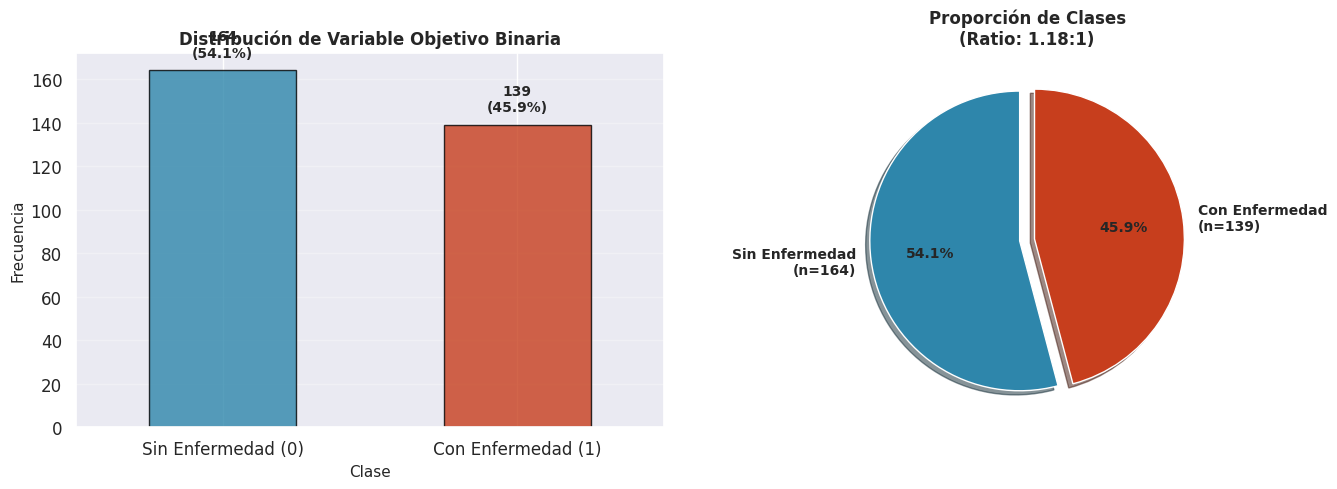


✓ Figura guardada: outputs/09_target_transformation.png


In [18]:
# ============================================================================
# TRANSFORMACIÓN DE VARIABLE OBJETIVO
# ============================================================================

print("\n" + "="*80)
print("TRANSFORMACIÓN DE VARIABLE OBJETIVO")
print("="*80)

print("\n📊 Distribución ORIGINAL (5 clases):")
print("-"*80)
original_dist = df_processed['num'].value_counts().sort_index()
for val, count in original_dist.items():
    pct = (count / len(df_processed)) * 100
    print(f"   Clase {val}: {count:3d} ({pct:5.2f}%)")

# Crear variable objetivo binaria
df_processed['target'] = (df_processed['num'] > 0).astype(int)

print("\n📊 Distribución BINARIA (2 clases):")
print("-"*80)
binary_dist = df_processed['target'].value_counts().sort_index()
for val, count in binary_dist.items():
    label = "Sin enfermedad" if val == 0 else "Con enfermedad"
    pct = (count / len(df_processed)) * 100
    print(f"   Clase {val} ({label:16s}): {count:3d} ({pct:5.2f}%)")

# Análisis de balance
print("\n📈 ANÁLISIS DE BALANCE DE CLASES:")
print("-"*80)
class_0 = binary_dist[0]
class_1 = binary_dist[1]
ratio = class_0 / class_1 if class_0 > class_1 else class_1 / class_0
minority_class = 0 if class_0 < class_1 else 1
majority_class = 1 - minority_class

print(f"• Clase mayoritaria ({majority_class}): {binary_dist[majority_class]} muestras")
print(f"• Clase minoritaria ({minority_class}): {binary_dist[minority_class]} muestras")
print(f"• Ratio de desbalanceo: {ratio:.2f}:1")

# Decisión sobre balanceo
if 0.8 <= ratio <= 1.25:
    balance_decision = "BALANCEADO"
    action = "No se requieren técnicas de balanceo"
    color_status = "✅"
elif 0.5 <= ratio < 0.8 or 1.25 < ratio <= 2.0:
    balance_decision = "LIGERAMENTE DESBALANCEADO"
    action = "Se recomienda usar class_weight='balanced' en modelos"
    color_status = "⚠️ "
else:
    balance_decision = "DESBALANCEADO"
    action = "Se recomienda SMOTE o técnicas de resampling"
    color_status = "⚠️ "

print(f"\n{color_status} Dataset {balance_decision}")
print(f"   Estrategia: {action}")
print("="*80)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Barras
binary_dist.plot(kind='bar', ax=axes[0], color=[COLOR_PALETTE[0], COLOR_PALETTE[3]],
                 edgecolor='black', alpha=0.8)
axes[0].set_title('Distribución de Variable Objetivo Binaria', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Clase', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_xticklabels(['Sin Enfermedad (0)', 'Con Enfermedad (1)'], rotation=0)
axes[0].grid(alpha=0.3, axis='y')

for i, v in enumerate(binary_dist):
    pct = (v / len(df_processed)) * 100
    axes[0].text(i, v + 5, f'{v}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Pie
labels = [f'Sin Enfermedad\n(n={binary_dist[0]})', f'Con Enfermedad\n(n={binary_dist[1]})']
colors = [COLOR_PALETTE[0], COLOR_PALETTE[3]]
explode = (0.05, 0.05)

axes[1].pie(binary_dist, labels=labels, colors=colors, autopct='%1.1f%%',
            explode=explode, shadow=True, startangle=90,
            textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title(f'Proporción de Clases\n(Ratio: {ratio:.2f}:1)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/09_target_transformation.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"\n✓ Figura guardada: {OUTPUT_DIR}/09_target_transformation.png")

<a id='44-split'></a>
## 4.4 División del Dataset

División estratificada del dataset en conjuntos de entrenamiento (80%) y prueba (20%), preservando la proporción de clases en ambos conjuntos.

**Parámetros:**
- **Test size**: 20% (61 muestras)
- **Train size**: 80% (242 muestras)
- **Estratificación**: Sí (mantiene balance de clases)
- **Random state**: 42 (reproducibilidad)

In [ ]:
# ============================================================================
# DIVISIÓN DEL DATASET (TRAIN-TEST SPLIT)
# ============================================================================

print("\n" + "="*80)
print("DIVISIÓN DEL DATASET")
print("="*80)

# Separar features y target
X = df_processed.drop(['num', 'target'], axis=1)
y = df_processed['target']

print(f"\n📊 Dataset completo:")
print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {y.shape}")
print(f"   • Total muestras: {len(X)}")

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\n📊 Conjuntos de entrenamiento y prueba:")
print("="*80)
print(f"TRAIN SET:")
print(f"   • X_train: {X_train.shape}")
print(f"   • y_train: {y_train.shape}")
print(f"   • Distribución de clases: {dict(y_train.value_counts().sort_index())}")

print(f"\nTEST SET:")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_test: {y_test.shape}")
print(f"   • Distribución de clases: {dict(y_test.value_counts().sort_index())}")

# Verificar estratificación
train_ratio = y_train.value_counts(normalize=True).sort_index()
test_ratio = y_test.value_counts(normalize=True).sort_index()

print(f"\n📈 VERIFICACIÓN DE ESTRATIFICACIÓN:")
print("="*80)
print(f"Proporción clase 0 - Train: {train_ratio[0]:.3f}, Test: {test_ratio[0]:.3f}")
print(f"Proporción clase 1 - Train: {train_ratio[1]:.3f}, Test: {test_ratio[1]:.3f}")
print(f"\n✅ Estratificación exitosa: Las proporciones son similares")
print("="*80)


In [ ]:
# Guardar productos de datos para los siguientes capítulos
print("\nGuardando productos de datos...")

# Guardar DataFrame procesado
save_data_product(df_processed, 'df_processed.pkl', 'pickle')

# Guardar train-test split
save_data_product({
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}, 'train_test_split.pkl')

print(f"\n✓ Datos guardados en: {PROCESSED_DATA_DIR}")
